index
AAACATACAACCAC-1    0.030190
AAACATTGAGCTAC-1    0.037990
AAACATTGATCAGC-1    0.008906
AAACCGTGCTTCCG-1    0.017477
AAACCGTGTATGCG-1    0.012257
Name: percent_mito, dtype: float32
                  total_counts  n_genes_by_counts
index                                            
AAACATACAACCAC-1        2418.0                778
AAACATTGAGCTAC-1        4896.0               1346
AAACATTGATCAGC-1        3144.0               1126
AAACCGTGCTTCCG-1        2632.0                953
AAACCGTGTATGCG-1         979.0                520


C:\Users\dan23\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\preprocessing\_qc.py:145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


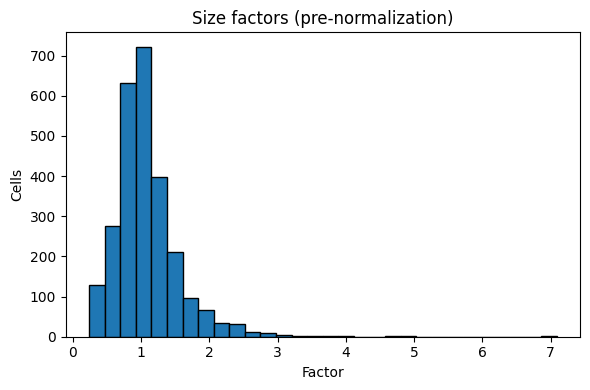

                  gene_ids  n_cells  n_cells_by_counts  mean_counts  \
index                                                                 
LINC00115  ENSG00000225880       18                 17     0.006459   
NOC2L      ENSG00000188976      258                256     0.108663   
HES4       ENSG00000188290      145                144     0.080547   
ISG15      ENSG00000187608     1204               1185     1.217325   
C1orf159   ENSG00000131591       24                 24     0.009119   

           log1p_mean_counts  pct_dropout_by_counts  total_counts  \
index                                                               
LINC00115           0.006438              99.354103          17.0   
NOC2L               0.103154              90.273556         286.0   
HES4                0.077467              94.528875         212.0   
ISG15               0.796302              54.977204        3204.0   
C1orf159            0.009077              99.088146          24.0   

           log1p_t

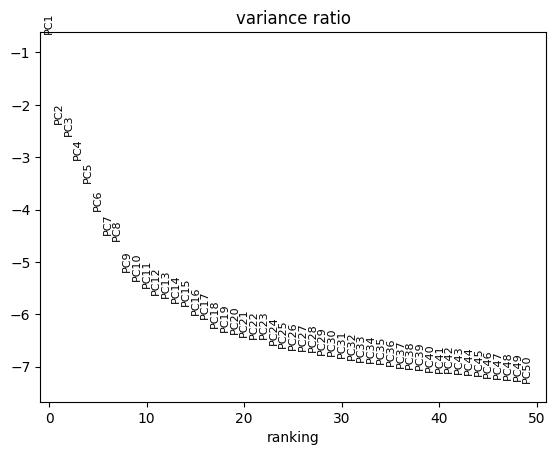

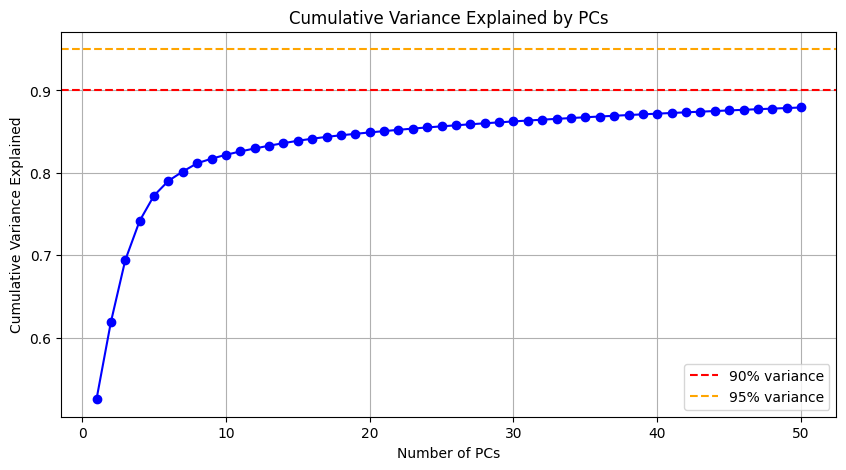

PCs needed for 90% variance: 1
20 PCs explain 84.9% of total variance
30 PCs explain 86.2% of total variance
40 PCs explain 87.2% of total variance
50 PCs explain 87.9% of total variance


Given that 30 PCs expain 86.2% of total variance:



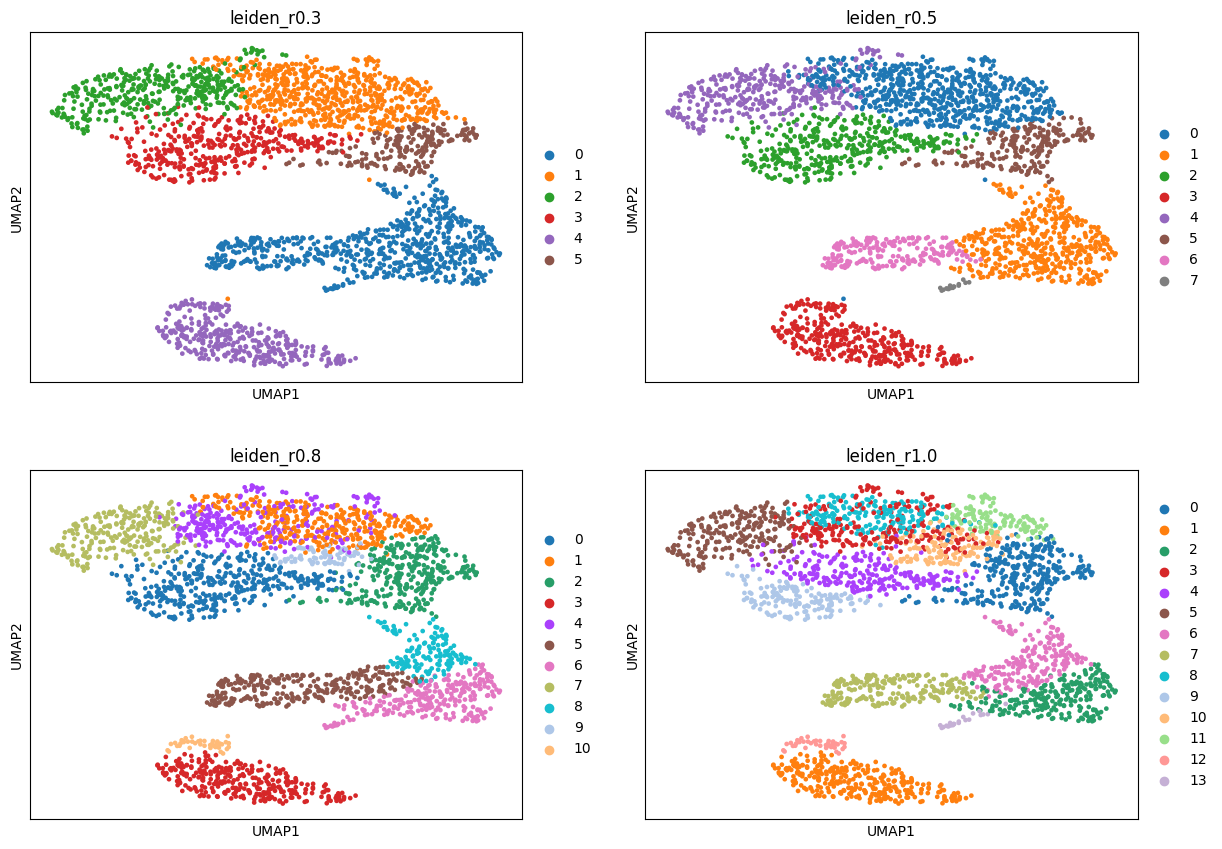


### **Conclusion**
This notebook implemented the single-cell RNA-seq analysis workflow
up to clustering (Sections 1–10 of *sc-best-practices*), using the PBMC3k dataset.

- The pipeline included QC, normalization, log transformation,
  selection of 1500 highly variable genes, PCA, neighborhood graph construction,
  Leiden clustering, and UMAP visualization.
- The resulting UMAP revealed ~7 transcriptionally distinct clusters,
  corresponding to major immune cell types (T, B, NK, monocytes, dendritic).

### **Next Steps (Future Work)**
- **Annotation:** identify marker genes per cluster and assign biological identities.
- **Integration:** merge multiple datasets to study batch effects.
- **Differential expression:** characterize transcriptional differences between conditions.
- **Trajectory inference:** reconstruct dynamic cell-state transitions.
- **Machine learning:** explore supervised classification of known cell types.


In [13]:
# ------------This notebook reproduces the sc-best-practices pipeline on the PBMC3k dataset using Scanpy
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import math

# Load the 10x PBMC 3k dataset
adata = sc.datasets.pbmc3k()

# Filter out cells with less than 300 genes
sc.pp.filter_cells(adata, min_genes=300)
gene_filter = max(10,math.floor(0.001*adata.n_obs))
# Filter out genes scaled with the number of cells, min 10
sc.pp.filter_genes(adata, min_cells=gene_filter)

# Add mitochondrial gene fraction (for each cells) as a new column in adata.obs
adata.obs['percent_mito'] = (
    adata[:, adata.var_names.str.startswith('MT-')].X.sum(1).A1 / adata.X.sum(1).A1
)
print(adata.obs['percent_mito'].head())
# Filter cells with >5% mitochondrial reads (Asuume healthy cells have 1-5% MT reads)
# reason : during cell stress cytoplasmic mRNA leaks but mtRNA remains -> %MT goes up
adata = adata[adata.obs['percent_mito'] < 0.05, :]


sc.pp.calculate_qc_metrics(adata, inplace=True)
print(adata.obs[["total_counts", "n_genes_by_counts"]].head()) # pre-normalization values

# Normalize UMI count per cell by 10,000
adata.layers["counts"] = adata.X.copy() # preserve raw counts
adata.layers["counts_norm"] = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=1e4, layer="counts_norm", inplace=True)
# 3. Log-transform (variance stabilizer)
sc.pp.log1p(adata, layer="counts_norm")

adata.layers["logcounts"] = adata.layers["counts_norm"].copy()

pre_counts = np.array(adata.layers["counts"].sum(axis=1)).ravel()
size_factors = pre_counts / np.median(pre_counts)
plt.figure(figsize=(6,4))
plt.hist(size_factors, bins=30, edgecolor="black")
plt.title("Size factors (pre-normalization)")
plt.xlabel("Factor")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()


# Feature selection (identify HVGs)
sc.pp.highly_variable_genes(
    adata,
    layer="counts",       
    flavor="seurat_v3",       
    n_top_genes=1500          # choose the 1.5k genes with highest variance (might imply biological importance)
)
print(adata.var.head())
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
hvg_sorted = (
    adata.var[adata.var["highly_variable"]]
    .sort_values("variances_norm", ascending=False)
)
hvg_sorted.head(10) # 10 highest variable genes 
#if a gene appears in many different cells and has high variance among them -> potential marker
# CD74/HLA-DRA - antigen presentation in B/ dendritic cells , LYZ/NKG7 - markers for NK/T (?)


# PCA  (Principal Component Analysis)
# Reduce 1500 → few dozen PCs (denoising)
sc.tl.pca(adata_hvg, svd_solver='arpack')

# visualize explained variance (to decide how many PCs to keep)
sc.pl.pca_variance_ratio(adata_hvg, log=True, n_pcs=50)

# Calculate cumulative variance
cumvar = np.cumsum(adata_hvg.uns['pca']['variance_ratio'])

# Plot it
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumvar)+1), cumvar, 'bo-')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% variance')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by PCs')
plt.legend()
plt.grid(True)
plt.show()

# Find how many PCs for 90% variance
n_pcs_90 = np.argmax(cumvar >= 0.90) + 1
print(f"PCs needed for 90% variance: {n_pcs_90}")

# Check specific PC counts
for n in [20, 30, 40, 50]:
    if n <= len(cumvar):
        print(f"{n} PCs explain {cumvar[n-1]:.1%} of total variance")
print('\n') 
#  k-nearest-neighbor graph based on PCA space
print(f"Given that 30 PCs expain {cumvar[29]:.1%} of total variance:\n")
sc.pp.neighbors(adata_hvg, n_neighbors=10, n_pcs=30,random_state=42)

# Test multiple resolutions
resolutions = [0.3, 0.5, 0.8, 1.0]
for res in resolutions:
    sc.tl.leiden(adata_hvg, resolution=res, key_added=f'leiden_r{res}',random_state=42)

sc.tl.umap(adata_hvg,random_state=42)
# Visualize side-by-side
sc.pl.umap(adata_hvg, color=[f'leiden_r{res}' for res in resolutions], ncols=2)



display(Markdown("""
### **Conclusion**
This notebook implemented the single-cell RNA-seq analysis workflow
up to clustering (Sections 1–10 of *sc-best-practices*), using the PBMC3k dataset.

- The pipeline included QC, normalization, log transformation,
  selection of 1500 highly variable genes, PCA, neighborhood graph construction,
  Leiden clustering, and UMAP visualization.
- The resulting UMAP revealed ~7 transcriptionally distinct clusters,
  corresponding to major immune cell types (T, B, NK, monocytes, dendritic).

### **Next Steps (Future Work)**
- **Annotation:** identify marker genes per cluster and assign biological identities.
- **Integration:** merge multiple datasets to study batch effects.
- **Differential expression:** characterize transcriptional differences between conditions.
- **Trajectory inference:** reconstruct dynamic cell-state transitions.
- **Machine learning:** explore supervised classification of known cell types.
"""))

